In [1]:
!pip install datasets
!pip install umap-learn
!pip install accelerate -U
!pip install transformers[torch]
!pip install transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=fd4cd695f2f76bfb1f30325e43d8805bd26465e6b57fb41f39b723eb4f33bd33
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━

1. distilbert variant of bert
2. change checkpoint of the pretrained model to train a large model
3. checkpoint corresponds set of weights that are loaded into a given transformer architecture
4. dataset -> tokenizers -> transformers -> metrics

In [2]:
import accelerate
import transformers

In [3]:
# from datasets import list_datasets
# all_datasets = list_datasets()
# print(f"The first 10 are : {all_datasets[:10]}")

In [4]:
# loading the dataset
from datasets import load_dataset
emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [11]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [12]:
import pandas as pd
emotions.set_format(type = "pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [14]:
df['label_name'] = df['label'].apply(lambda x: labels[x])

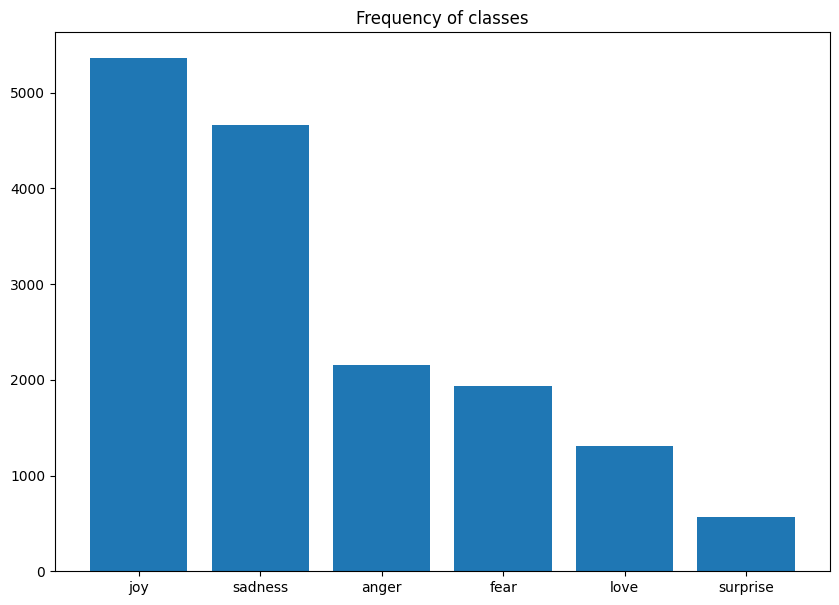

In [15]:
# class distribution
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
plt.title("Frequency of classes")
plt.bar(df["label_name"].value_counts().index, df["label_name"].value_counts().values)
plt.show()

1. the joy and sadness classes appear frequently where love and surprise are about 5 to 10 times rarer
2. dealing with imbalanced data
  1. randomly oversample the minority class
  2. randomly undersample the majority class
  3. gather mode labeled data from the underrepresented classes

In [16]:
df["words per tweet"] = df["text"].str.split().apply(len)

1. transformer model have max input seq length - max context size
2. for distilbert the max context size is 512 tokens

In [17]:
import seaborn as sns

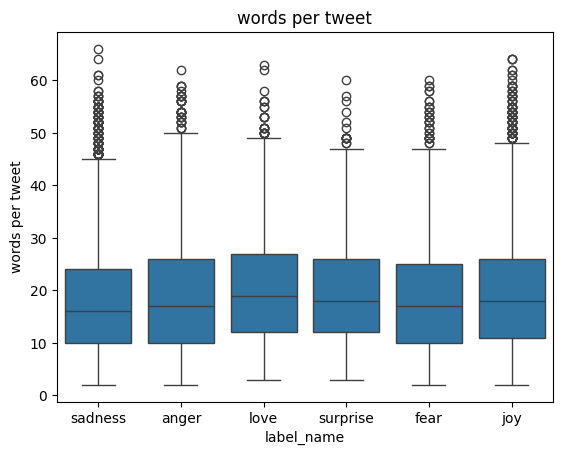

In [18]:
sns.boxplot(x = df["label_name"], y = df["words per tweet"])
plt.title("words per tweet")
plt.show()

1. most tweets are around 15 words long and the longest tweets are well below distilbert's max context size
2. text that are longer than a model's context size need to be truncated which leads to a loss in perf if truncated data contains crucial information

In [19]:
# resetting the format of the dataset
emotions.reset_format()

In [20]:
# character tokenization
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
# tokenized_text

In [21]:
token2idx = {ch : idx for idx, ch in enumerate (sorted(set(tokenized_text)))}
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [22]:
input_ids = [token2idx[token] for token in tokenized_text]
input_ids

[5,
 14,
 12,
 8,
 13,
 11,
 19,
 11,
 13,
 10,
 0,
 17,
 8,
 18,
 17,
 0,
 11,
 16,
 0,
 6,
 0,
 7,
 14,
 15,
 8,
 0,
 17,
 6,
 16,
 12,
 0,
 14,
 9,
 0,
 3,
 2,
 4,
 1]

In [23]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [24]:
len(input_ids)

38

In [25]:
len(token2idx)

20

1. treats the whole string as a stream of characters
2. helps in misspellings and rare words
3. lacks structure
4. lingustic structure such as words need to be learned from the data that requires compute, memory and data

In [26]:
# word tokenization

tokeized_text = text.split()
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


1. some stemming or lemmatization can be used to normalize the words to their steam(great, greatest, greater becomes great)
2. increases the vocab size
3. limiting the vocab size and not common words are classificed as unk token this may lead to loss in info if it contains useful information

In [27]:
# subword tokenization
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1. combines the aspect of both character and word tokenization
2. we want to split rare words into smaller units to deal with complex and misspellings
3. we want to keep the vocab size to a manageable size
4. ##prefix in some words indicate the preceding text is not a white space and any token with that prefix is merged with the previous token

In [28]:
# subword tokenization(manual tokenizer)
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [29]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [31]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [32]:
tokenizer.vocab_size

30522

In [33]:
tokenizer.model_max_length

512

In [34]:
# names of the fields that the model expects in forward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [35]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenizing the entire dataset

In [36]:
# mapping function
def tokenize(batch):
  return tokenizer(batch["text"], padding = True, truncation = True)

In [37]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


* padding = True means it adds zero to match the longest length of words
* truncation = True means it truncates the tokens if it exceeds the models max token size

In [38]:
# applying the tokenize function to the dataset
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [39]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a text classificer

In [40]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [41]:
text = "this is a text"
inputs = tokenizer(text, return_tensors = "pt")
inputs["input_ids"].shape

torch.Size([1, 6])

In [42]:
inputs = {k : v.to(device) for k,v in inputs.items()}
with torch.inference_mode():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2535, -0.1091,  0.0759,  ..., -0.1054,  0.2257,  0.4615],
         [-0.7154, -0.2742, -0.0954,  ..., -0.3597,  0.5174,  0.3450],
         [-0.4100, -0.2195,  0.1850,  ..., -0.0136,  0.1607,  1.0422],
         [-0.2523, -0.0254,  0.2472,  ..., -0.1637,  0.0865,  1.0516],
         [-0.0570, -0.1057,  0.0662,  ...,  0.0584,  0.1034,  0.2971],
         [ 0.9184,  0.1577, -0.4105,  ...,  0.1509, -0.7327, -0.1572]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [43]:
outputs["last_hidden_state"].shape

torch.Size([1, 6, 768])

1. for classification task we can take the hidden state associated with the [CLS] token as input feature

In [44]:
# func for extracting the hidden states for every batch
def extract_hidden_states(batch):

  # place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.inference_mode():
    last_hidden_state = model(**inputs).last_hidden_state

  # return vector for [CLS] token
  return {"hidden_state" : last_hidden_state[:, 0].cpu().numpy()}

In [45]:
# converting the dataset to torch.tensors
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [46]:
# extracting hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## creating a feature matrix

In [48]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## visualizing the training set

1. visualizng the hidden states in 768 dimensions is tricky using umap to project vectors down to 2-d

In [49]:
# import umap
# from sklearn.preprocessing import MinMaxScaler

# # scale features to [0, 1] range
# X_scaled = MinMaxScaler().fit_transform(X_train)

# # initilize and fit umap
# mapper = umap.UMAP(n_components = 2, metric = "cosine").fit(X_scaled)

# # create a data frame of 2d embeddings
# df_emb = pd.DataFrame(mapper.embedding_, columns = ["X", "Y"])
# df_emb["label"] = y_train
# df_emb.head()

In [50]:
# fig, axes = plt.subplots(2, 3, figsize = (7, 5))
# axes = axes.flatten()
# cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
# labels = emotions["train"].features["label"].names

# for i, (label, cmap) in enumerate(zip(labels, cmaps)):
#   df_emb_sub = df_emb.query(f"label == {i}")
#   axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap = cmap, gridsize = 20, linewidths = (0,))
#   axes[i].set_title(label)
#   axes[i].set_xticks([])
#   axes[i].set_yticks([])
# plt.tight_layout()
# plt.show()

1. There are the projections onto a lower dimensional space
2. if some categories overlap here it does not mean that they are not seperable in the original space
3. if they are seperable in the prjected space they will be seperable in the orginal space

1. sadness, anger, fear all occupy similar regions with slightly varying distributions
2. joy and love are well seprated from negative emotions and share similar space
3. surprise is scatter all over the place

In the context of Natural Language Processing (NLP), masked words refer to a technique commonly used in pre-trained language models, such as BERT (Bidirectional Encoder Representations from Transformers). The idea behind masked words is to randomly replace some of the words in a given sentence with a special token, often "[MASK]," and then train the model to predict the original words based on the context provided by the surrounding words.

During pre-training, a language model like BERT is exposed to vast amounts of text data and learns to understand the relationships between words by predicting missing or masked words. This process helps the model capture contextual information and semantic meaning, allowing it to perform well on a variety of downstream NLP tasks such as text classification, named entity recognition, and question answering.

After pre-training, the fine-tuning process adapts the model to specific tasks using labeled datasets. This enables the model to generalize its understanding to various natural language tasks by leveraging the knowledge gained during pre-training. The masked word prediction task is just one of the techniques used in the training of modern language models to improve their ability to understand and generate human-like language.

## Training a simple classifier

In [51]:
# from sklearn.linear_model import LogisticRegression

# lr_clf = LogisticRegression(max_iter = 3000)
# lr_clf.fit(X_train, y_train)
# lr_clf.score(X_valid, y_valid)

1. above model is better than random since we are dealing with unbalanced data it's actually better


In [52]:
# # comparing above model against simple baseline
# # chooses the most frequent class
# from sklearn.dummy import DummyClassifier

# dummy_clf = DummyClassifier(strategy = "most_frequent")
# dummy_clf.fit(X_train, y_train)
# dummy_clf.score(X_valid, y_valid)

1. simple classifier with distilbert embeddings is better than the baseline model

In [53]:
# plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize = 'true')
  fig, ax = plt.subplots(figsize = (6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  disp.plot(cmap = "Blues", values_format = ".2f", ax = ax, colorbar = False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

In [54]:
# y_preds = lr_clf.predict(X_valid)
# plot_confusion_matrix(y_preds, y_valid, labels)

# Fine-Tuning Transformers

using trainer API from transformers to simplify the training look

## Loading a pretrained model

using AutoModelForSequenceClassification model instead of AutoModel. The difference is that AutoModelSequenceClassification model has classification head on top of pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict

In [55]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels = num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


the classification head has not yet been trained

## Defining the performance metrics

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy" : acc, "f1" : f1}

## training the model

In [57]:
from google.colab import userdata
token = userdata.get("textclassification")
print(token)

SecretNotFoundError: Secret textclassification does not exist.

In [58]:
from huggingface_hub import notebook_login
notebook_login()

In [59]:
# from transformers import  TrainingArguments
import accelerate
import transformers

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = transformers.TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  disable_tqdm = False,
                                  evaluation_strategy = "epoch",
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error")

In [60]:
from transformers import Trainer
trainer = Trainer(model = model,
                  args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded["train"],
                  eval_dataset = emotions_encoded["validation"],
                  tokenizer = tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.853700,0.323516,0.897000,0.895785
2,0.250600,0.219451,0.923500,0.923296


In [61]:
# predicting on the validation data
preds_pt = trainer.predict(emotions_encoded["validation"])

In [62]:
preds_pt.metrics

{'test_loss': 0.2194512039422989,
 'test_accuracy': 0.9235,
 'test_f1': 0.923296474937779,
 'test_runtime': 4.4213,
 'test_samples_per_second': 452.361,
 'test_steps_per_second': 7.238}

1. it also contains the raw predictions for each class

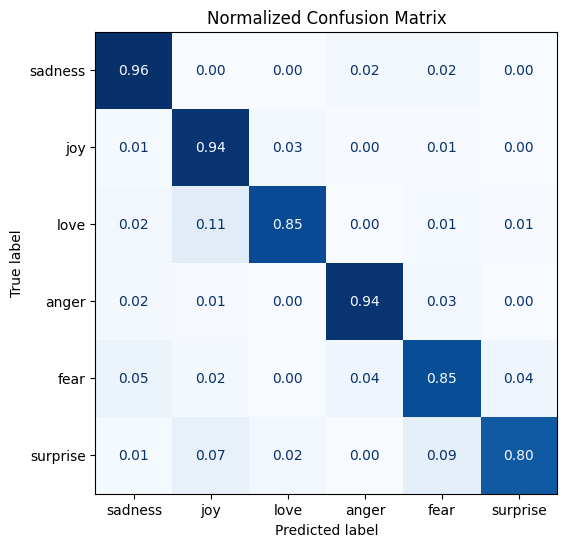

In [63]:
y_preds_pt = np.argmax(preds_pt.predictions, axis = 1)

# plotting confusion matrix
plot_confusion_matrix(y_preds_pt, y_valid, labels)

1. the model got confused with love and joy. It predicted joy when some of them is love which seems natural
2. also the model got confused with surprise. It predicted some of them as joy and fear instead of surprise

## Fine-Tunning with Keras
while using tensorflow we can fine-tune models using the KERAS API. It has built in fit() method and no trainer class like the one in PyTorch API

In [64]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels = num_labels))

converting the dataset to tf dataset using to_tf_dataset() to meet the requirements for using keras api

In [65]:
# converting the tokenized dataset to tf dataset
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns = tokenizer_columns, label_cols = ["label"],
    shuffle = True,
    batch_size = batch_size
)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns = tokenizer_columns,
    label_cols = ["label"],
    shuffle = False,
    batch_size = batch_size
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [66]:
# training the model using keras api
import tensorflow as tf

tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = tf.metrics.SparseCategoricalAccuracy()
)

tf_model.fit(tf_train_dataset,
             validation_data = tf_eval_dataset,
             epochs = 2)

Epoch 1/2
250/250 [==============================] - 187s 548ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.8153 - val_loss: 0.2016 - val_sparse_categorical_accuracy: 0.9240
Epoch 2/2
250/250 [==============================] - 130s 520ms/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.1268 - val_sparse_categorical_accuracy: 0.9425


Sparse categorical accuracy is a metric commonly used in machine learning, especially in the context of neural networks for classification tasks. It is calculated as the number of correctly predicted instances for the target class divided by the total number of instances.

To be more specific:

Sparse Categorical Accuracy = Number of Correctly Predicted Instances / Total Number of Instances

In the case of sparse categorical accuracy, it is often used when the labels are integers (e.g., class indices) rather than one-hot encoded vectors. The "sparse" in its name refers to the fact that the true labels are provided as integers (sparse representation) rather than one-hot encoded vectors (dense representation).

So, in summary, it is indeed the count of correctly predicted instances divided by the total number of predictions, but it's specifically applied when dealing with integer-encoded class labels.

32/32 [==============================] - 6s 139ms/step


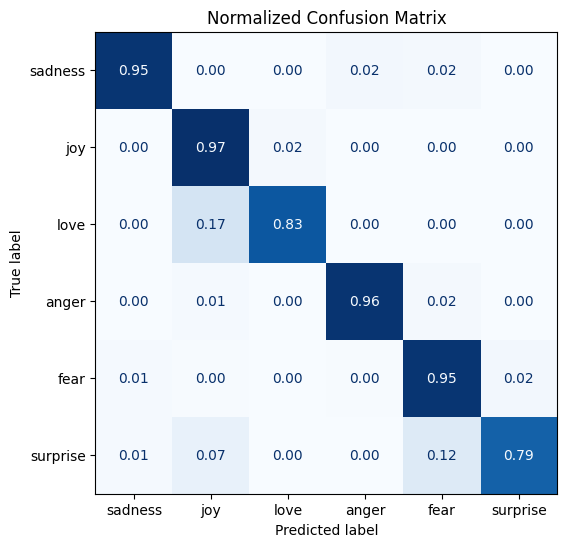

In [67]:
y_preds_tf = np.argmax(tf_model.predict(tf_eval_dataset).logits, axis = 1)

# plotting confusion matrix for tf model
plot_confusion_matrix(y_preds_tf, y_valid, labels)

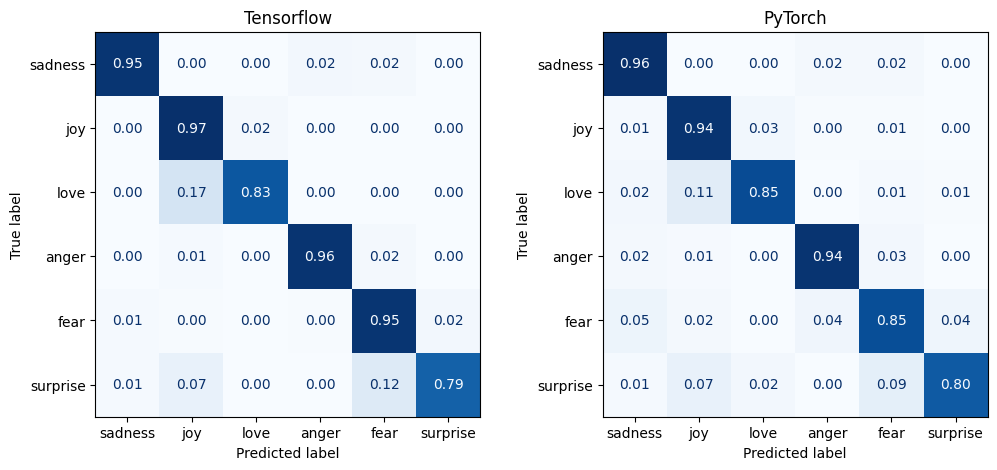

In [68]:
# plotting confusion matrix for both pytorch and tensorflow model and both are trained for 2 epochs
def plot_confusion_matrix(y_preds_tf, y_preds_pt, y_true, labels):
  fig, axes = plt.subplots(1, 2, figsize = (12, 5))
  cm_tf = confusion_matrix(y_true, y_preds_tf, normalize = 'true')
  cm_pt = confusion_matrix(y_true, y_preds_pt, normalize = 'true')
  disp_tf = ConfusionMatrixDisplay(confusion_matrix = cm_tf, display_labels = labels)
  disp_pt = ConfusionMatrixDisplay(confusion_matrix = cm_pt, display_labels = labels)
  disp_tf.plot(cmap = "Blues", values_format = ".2f", ax = axes[0], colorbar = False)
  disp_pt.plot(cmap = "Blues", values_format = ".2f", ax = axes[1], colorbar = False)
  axes[0].set_title("Tensorflow")
  axes[1].set_title("PyTorch")
  plt.show()

plot_confusion_matrix(y_preds_tf, y_preds_pt, y_valid, labels)

## Error analysis

In [69]:
import numpy as np

In [70]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # place all input tensorss on the same device as the model
  inputs = {k : v.to(device) for k, v in batch.items()
            if k in tokenizer.model_input_names}

  with torch.inference_mode():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis = -1),
    loss = cross_entropy(output.logits,
                         batch["label"].to(device),
                         reduction = "none")

  # place outputs on cpu for compatibility with other dataset columns
  return {"loss" : loss,
            "output_logits" : output.logits}

In [71]:
# using map method to compute the losses for all the samples

# convert our dataset back to pytorch tensors
emotions_encoded.set_format("torch",
                            columns = ["input_ids", "attention_mask", "label"])

# compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched = True,
                                                                    batch_size = 16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [72]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "output_logits", "loss"]
df_test = emotions_encoded["validation"][:][cols]

In [73]:
df_test["predicted_label"] = df_test["output_logits"].apply(lambda x : np.argmax(x))

In [74]:
label_dict = {i : labels[i] for i in range(len(labels))}
label_dict

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [75]:
df_test[["predicted_label", "label"]] = df_test[["predicted_label", "label"]].replace(label_dict)

In [90]:
df_test.sort_values("loss", ascending = False).head(10)

,text,label,output_logits,loss,predicted_label
1950,i as representative of everything thats wrong ...,surprise,"[3.4680815, -1.1708108, -1.8415996, 1.1100867,...",5.556944,sadness
1963,i called myself pro life and voted for perry w...,joy,"[3.8983426, -1.3576488, -1.1388916, -0.1126643...",5.305911,sadness
882,i feel badly about reneging on my commitment t...,love,"[3.4326234, -0.59110284, -1.6783965, 0.7716352...",5.220197,sadness
1801,i feel that he was being overshadowed by the s...,love,"[4.071471, -0.75424206, -0.87233037, -0.929799...",4.979969,sadness
1509,i guess this is a memoir so it feels like that...,joy,"[0.13551404, -1.288383, -1.3879347, -0.9505784...",4.970778,fear
1870,i guess i feel betrayed because i admired him ...,joy,"[3.5769184, -1.1778387, -0.46349433, -0.818754...",4.823200,sadness
1500,i guess we would naturally feel a sense of lon...,anger,"[4.2843747, -0.8608792, -1.1037171, -0.4985274...",4.809717,sadness
1111,im lazy my characters fall into categories of ...,joy,"[0.23640306, -1.6873248, -2.0475214, 1.9557683...",4.565818,fear
405,i have been feeling extraordinarily indecisive...,fear,"[-2.1552153, 3.273236, 0.4525951, -2.016532, -...",4.296227,joy
1683,i had applied for a job and they had assured m...,anger,"[-0.907729, 3.4793534, -1.1827734, -0.7358772,...",4.273014,joy


In [92]:
df_test.sort_values("loss", ascending = True).head(10)

,text,label,output_logits,loss,predicted_label
1873,i feel practically virtuous this month i have ...,joy,"[-1.4237986, 4.5504737, -0.7130102, -1.2840729...",0.016220,joy
1505,im feeling hopeful about a great deal of thing...,joy,"[-1.3845941, 4.5399165, -0.666625, -1.4946276,...",0.016611,joy
1205,i log on feeling vaguely sociable and after a ...,joy,"[-1.3749591, 4.5414786, -0.58795214, -1.436796...",0.016634,joy
578,i got to christmas feeling positive about the ...,joy,"[-1.3239833, 4.533265, -0.67640454, -1.3442787...",0.016641,joy
941,i expected but it did feel hopeful and it defi...,joy,"[-1.3034065, 4.5182724, -0.6394909, -1.4151322...",0.016916,joy
1265,im feeling more hopeful today than i did yeste...,joy,"[-1.2545577, 4.517784, -0.73379093, -1.4223977...",0.016923,joy
1263,i feel this way about blake lively,joy,"[-1.5053567, 4.519288, -0.5932072, -1.4356557,...",0.017054,joy
530,i feel pretty safe but i do realize that we do...,joy,"[-1.103302, 4.513775, -0.7744781, -1.2526917, ...",0.017084,joy
1421,i feel undeservingly lucky to be surrounded by...,joy,"[-1.333859, 4.5334177, -0.5009244, -1.4169365,...",0.017085,joy
1449,im also feeling brave enough to publish my tho...,joy,"[-1.4296385, 4.545243, -0.4256305, -1.3768531,...",0.017189,joy


## Saving and Sharing the model

In [78]:
trainer.push_to_hub(commit_message = "Training Completed!...")

events.out.tfevents.1707460041.41fe190b7f8c.2023.0:   0%|          | 0.00/5.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pt-sk/distilbert-base-uncased-finetuned-emotion/commit/cdb3b0d0225fcfac326862d338a22769baf620fa', commit_message='Training Completed!...', commit_description='', oid='cdb3b0d0225fcfac326862d338a22769baf620fa', pr_url=None, pr_revision=None, pr_num=None)

In [80]:
# making predictions on the custom tweets
from transformers import pipeline

model_id = f"pt-sk/{model_name}"
classifier = pipeline("text-classification", model = model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [81]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores = True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [86]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.01733517087996006},
 {'label': 'LABEL_1', 'score': 0.9460930824279785},
 {'label': 'LABEL_2', 'score': 0.0109243830665946},
 {'label': 'LABEL_3', 'score': 0.010435751639306545},
 {'label': 'LABEL_4', 'score': 0.0063101500272750854},
 {'label': 'LABEL_5', 'score': 0.008901547640562057}]

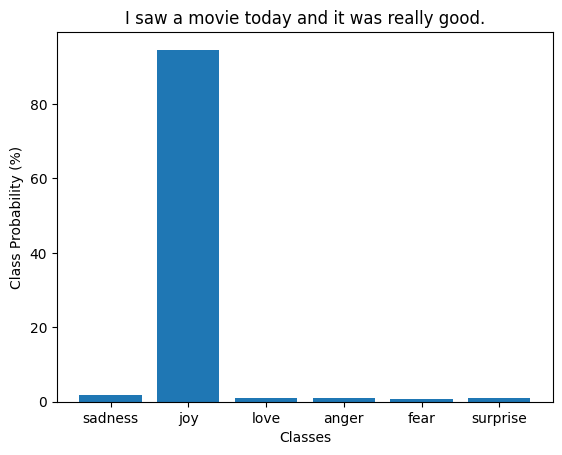

In [87]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color = "C0")
plt.title(f"{custom_tweet}")
plt.xlabel("Classes")
plt.ylabel("Class Probability (%)")
plt.show()